<a href="https://colab.research.google.com/github/jinweiRao/MEng-Project/blob/master/Test_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [710]:
import tensorflow
from tensorflow import keras
from keras import backend as K
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers import Dense,Activation,Input
import numpy as np
import pandas as pd
from keras import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
from keras import optimizers, regularizers
import seaborn as sns
from keras import callbacks
from scipy.stats.stats import pearsonr
import random
import matplotlib.pyplot
from sklearn.cluster import KMeans
from tqdm import tqdm
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import h5py

## Build baseline_model

In [524]:
data=pd.read_csv('plant_A.csv')
data.head()

,lp,Temp,CaO,MgO,SiO2,Fe_total,MnO,Al2O3,TiO2,V2O5
0,4.736198,1649,40.0,8.63,7.8,27.5,3.38,0.91,0.45,1.473
1,4.436094,1654,39.6,9.99,9.2,23.0,4.14,2.60,0.68,1.945
2,4.499810,1664,44.8,8.80,11.0,20.2,3.45,1.58,0.76,2.070
3,4.140865,1680,42.4,8.10,11.5,21.1,3.76,2.47,0.88,2.161
4,4.081441,1671,48.8,11.73,11.8,13.3,3.26,1.48,0.78,1.976


In [510]:
trial_data = stddata.drop(['CaO'],axis =1).copy()

In [521]:
def stdarize_data(data):
    mean = data.describe().loc['mean'].values
    std = data.describe().loc['std'].values
    stddata = (data - mean)/std
    return stddata

In [525]:
stddata = stdarize_data(data)
stddata.loc[:,'lp'] = data.loc[:,'lp']
stddata.head()

,lp,Temp,CaO,MgO,SiO2,Fe_total,MnO,Al2O3,TiO2,V2O5
0,4.736198,0.009329,-0.671236,-0.439794,-2.922204,2.626815,-2.034799,-1.869831,-2.451391,-1.341048
1,4.436094,0.270513,-0.781774,0.555023,-2.118590,1.352351,-0.943029,1.682121,-1.622410,-0.383367
2,4.499810,0.792881,0.655222,-0.315442,-1.085373,0.559351,-1.934241,-0.461660,-1.334069,-0.129743
3,4.140865,1.628670,-0.008007,-0.827481,-0.798368,0.814244,-1.488914,1.408894,-0.901557,0.054895
4,4.081441,1.158539,1.760603,1.827804,-0.626165,-1.394827,-2.207183,-0.671835,-1.261984,-0.320468


In [ ]:
T1 = stddata.loc[stddata['Temp']<=0.24].copy()
T2 = stddata.loc[stddata['Temp']>0.24].copy()
S1 = T1.loc[T1['SiO2'] <= 0.47].reset_index().drop(['index'],axis = 1)
S2 = T1.loc[T1['SiO2'] > 0.47].reset_index().drop(['index'],axis = 1)
S3 = T2.loc[T2['SiO2'] <= 0.33].reset_index().drop(['index'],axis = 1)
S4 = T2.loc[T2['SiO2'] > 0.33].reset_index().drop(['index'],axis = 1)
M1 = S1.loc[S1['MgO'] <= 0.72].reset_index().drop(['index'],axis = 1)
M2 = S1.loc[S1['MgO'] > 0.72].reset_index().drop(['index'],axis = 1)
M3 = S2.loc[S2['MgO'] <= 0.81].reset_index().drop(['index'],axis = 1)
M4 = S2.loc[S2['MgO'] > 0.81].reset_index().drop(['index'],axis = 1)
M5 = S3.loc[S3['MgO'] <= 0.36].reset_index().drop(['index'],axis = 1)
M6 = S3.loc[S3['MgO'] > 0.36].reset_index().drop(['index'],axis = 1)
M7 = S4.loc[S4['MgO'] <= -0.17].reset_index().drop(['index'],axis = 1)
M8 = S4.loc[S4['MgO'] > -0.17].reset_index().drop(['index'],axis = 1)

In [526]:
act_list = ['sigmoid','tanh','softsign','softmax','relu','elu']
opt_list = ['adam','RMSprop','Adadelta','SGD']

In [527]:
def baseline_model(act,opt,nums):
    model = Sequential()
    model.add(Dense(nums, input_dim = 9, activation = act))
    model.add(Dense(1, activation = 'linear'))
    model.compile(loss='mse', optimizer = opt, metrics=['mse']) 
    return model

In [528]:
def generate_model():
    model_list = []
    for act in act_list:
        for opt in opt_list:
            model_list.append(baseline_model(act,opt,16))
    return model_list

In [529]:
modelList = generate_model()

In [770]:
def cv(df,model):
    kf = KFold(n_splits = 5, random_state = 10, shuffle = False)
    splits = kf.split(df)
    comparision_list = []
    for train_index,test_index in splits:
        X_train = df.loc[train_index,'Temp':'V2O5'].values
        X_test = df.loc[test_index,'Temp':'V2O5'].values
        y_train = df.loc[train_index,'lp'].values
        y_test = df.loc[test_index,'lp'].values
        model.fit(X_train, y_train, epochs = 7, batch_size = 20, validation_data = (X_test,y_test),verbose = 0)
        prediction = model.predict(X_test).reshape(len(X_test),)
        comparision = {'prediction':prediction,'truth':y_test}
        comparision_list.append(comparision)
    return comparision_list

In [751]:
def modelsearch(modelList,df):
    result_list = [] 
    for model in modelList:
        result = cv(df,model)
        result_list.append(result)
    return result_list

In [735]:
def get_result(data):
    R_list = []
    RMSE_list = []
    for model_index in range(len(data)):
        rmse_list = []
        r_list = []
        for k in range(5):
            pre = data[model_index][k]['prediction']
            truth = data[model_index][k]['truth']
            rmse = np.sqrt(sum((pre - truth)**2)/len(pre))
            r = pearsonr(pre,truth)[0]
            rmse_list.append(rmse)
            r_list.append(r)
        R_list.append(np.mean(r_list))
        RMSE_list.append(np.mean(rmse_list))
    return R_list, RMSE_list

In [532]:
def allsearch():
    final_list = []
    for df in tqdm([M1,M2,M3,M4,M5,M6,M7,M8]):
        final = modelsearch(modelList,df)
        final_list.append(final)
    return final_list

In [533]:
M1_result,M2_result,M3_result,M4_result,M5_result,M6_result,M7_result,M8_result = allsearch()







  0%|          | 0/8 [00:00<?, ?it/s]





 12%|█▎        | 1/8 [1:00:17<7:02:01, 3617.36s/it]





 25%|██▌       | 2/8 [1:30:37<5:07:49, 3078.22s/it]





 38%|███▊      | 3/8 [2:04:30<3:50:23, 2764.73s/it]





 50%|█████     | 4/8 [2:10:33<2:16:16, 2044.03s/it]





 62%|██████▎   | 5/8 [2:31:36<1:30:29, 1809.72s/it]





 75%|███████▌  | 6/8 [2:45:08<50:20, 1510.35s/it]  





 88%|████████▊ | 7/8 [3:05:50<23:49, 1429.98s/it]





100%|██████████| 8/8 [3:27:59<00:00, 1399.73s/it]

In [545]:
def get_namelist():
    namelist = []
    for act in act_list:
        for opt in opt_list:
            namelist.append(act +'-'+ opt)
    return namelist

In [546]:
namelist = get_namelist()
namelist[:5]

['sigmoid-adam',
 'sigmoid-RMSprop',
 'sigmoid-Adadelta',
 'sigmoid-SGD',
 'tanh-adam']

In [556]:
M1_final = get_result(M1_result)
M2_final = get_result(M2_result)
M3_final = get_result(M3_result)
M4_final = get_result(M4_result)
M5_final = get_result(M5_result)
M6_final = get_result(M6_result)
M7_final = get_result(M7_result)
M8_final = get_result(M8_result)

In [557]:
def plot_result(data):
    plt.figure(figsize = (9,9))
    p1 = plt.barh(y = range(24), width = data[0], height = 0.35, label = 'R')
    p2 = plt.barh(y = range(24), width = [0.1/i for i in data[1]], height = 0.35, label = '0.1/RMSE',left = data[0])
    plt.xlim(0,0.95,0.1)
    plt.yticks(range(24),(namelist))
    plt.ylabel('model_name',fontsize = 14)
    plt.legend()
    plt.show()

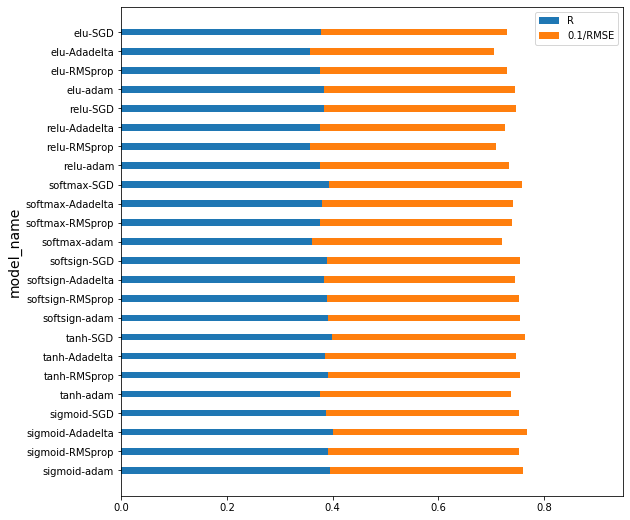

In [558]:
plot_result(M1_final)

In [548]:
def cv_result(data):
    rmse_list = []
    r_list = []
    for k in range(5):
        pre = data[k]['prediction']
        truth = data[k]['truth']
        rmse = np.sqrt(sum((pre - truth)**2)/len(pre))
        r = pearsonr(pre,truth)[0]
        rmse_list.append(rmse)
        r_list.append(r)
    return np.mean(rmse_list), np.mean(r_list)

### error histgram

In [549]:
def get_error(data):
    error = []
    for k in range(5):
        temp = []
        temp = data[k]['prediction'] - data[k]['truth']
        temp = temp.tolist()
        error += temp
    return error

In [561]:
383/13000*150

4.4192307692307695

In [771]:
test = modelsearch(modelList,M1)

In [772]:
test_result = get_result(test)

In [773]:
test_result 

([0.3839612029832502,
  0.3848085066707654,
  0.39629350703120375,
  0.4080017355604146,
  0.3689899909007751,
  0.3830762103415989,
  0.379586349107751,
  0.39562898273311065,
  0.37721128552727873,
  0.389477507265059,
  0.38671284404660855,
  0.39863487537044157,
  0.37054290061092937,
  0.35895252195667016,
  0.38607611876606596,
  0.41526233424752207,
  0.38643047976006695,
  0.3750568781164481,
  0.37951774468858707,
  0.3955070668212561,
  0.3842195843945152,
  0.38397862269975386,
  0.3817768310053759,
  0.38553137754677114],
 [0.2761317565232064,
  0.27582556584270534,
  0.2736274721004662,
  0.27237229301968846,
  0.2776408688802142,
  0.276445855427127,
  0.27715495120742906,
  0.2734360861678498,
  0.2773865541498781,
  0.2743913256473651,
  0.27665735005981174,
  0.2747175232717602,
  0.277212543466704,
  0.27780972237157747,
  0.27471940414122886,
  0.27025582546349475,
  0.2747056008424463,
  0.27708647897485056,
  0.28012869406759244,
  0.2783808250348633,
  0.278765498

In [774]:
tru = test[1][0]['truth']
pre = test[1][0]['prediction']

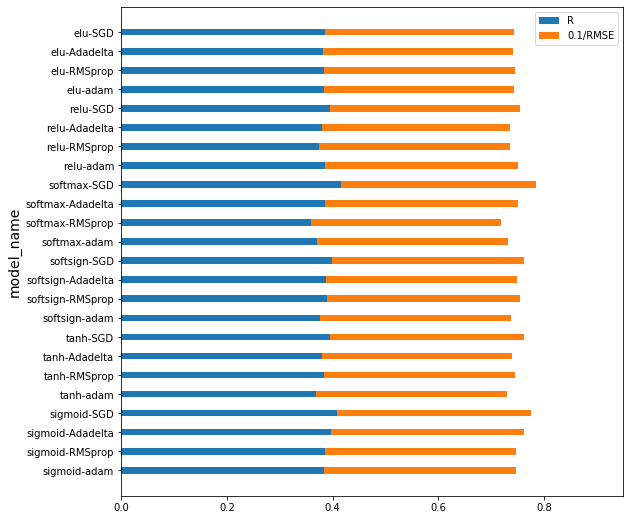

In [775]:
plot_result(test_result)

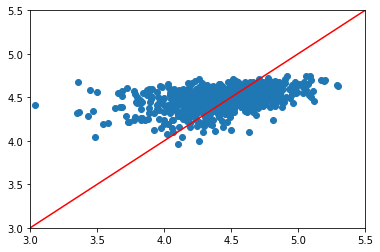

In [776]:
plt.scatter(x = tru, y = pre)
plt.ylim(3,5.5)

plt.xlim(3,5.5)

plt.plot([3,5.5],[3,5.5],color = 'red')

In [657]:
def test_baseline():
    model = Sequential()
    model.add(Dense(16, input_dim = 9, activation = 'tanh'))
    model.add(Dense(1, activation = 'linear'))
    model.compile(loss='mse', optimizer = 'RMSprop', metrics=['mse']) 
    return model

In [787]:
testModel = test_baseline()

In [783]:
len(M1)

4103

In [784]:
X_train,X_test = M1.loc[:,'Temp':'V2O5'][:3500], M1.loc[:,'Temp':'V2O5'][3500:]
y_train,y_test = M1.loc[:,'lp'][:3500],M1.loc[:,'lp'][3500:]

In [785]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 50)
mc = ModelCheckpoint('bestModel.h5', monitor='val_mean_squared_error', mode='min', verbose=1, save_best_only = True)

In [797]:
testModel = test_baseline()
hist = testModel.fit(X_train,y_train, epochs = 150, batch_size = 20, validation_data = (X_test,y_test),verbose = 1,
                    callbacks = [es,mc])

Train on 3500 samples, validate on 603 samples
Epoch 1/150
3500/3500 [==============================] - 2s 634us/step - loss: 11.1973 - mean_squared_error: 11.1973 - val_loss: 7.8212 - val_mean_squared_error: 7.8212

Epoch 00001: val_mean_squared_error did not improve from 0.06673
Epoch 2/150
3500/3500 [==============================] - 0s 81us/step - loss: 1.9302 - mean_squared_error: 1.9302 - val_loss: 1.1153 - val_mean_squared_error: 1.1153

Epoch 00002: val_mean_squared_error did not improve from 0.06673
Epoch 3/150
3500/3500 [==============================] - 0s 81us/step - loss: 0.4213 - mean_squared_error: 0.4213 - val_loss: 0.3590 - val_mean_squared_error: 0.3590

Epoch 00003: val_mean_squared_error did not improve from 0.06673
Epoch 4/150
3500/3500 [==============================] - 0s 78us/step - loss: 0.1963 - mean_squared_error: 0.1963 - val_loss: 0.1846 - val_mean_squared_error: 0.1846

Epoch 00004: val_mean_squared_error did not improve from 0.06673
Epoch 5/150
3500/3500 

3500/3500 [==============================] - 0s 87us/step - loss: 0.0745 - mean_squared_error: 0.0745 - val_loss: 0.0716 - val_mean_squared_error: 0.0716

Epoch 00036: val_mean_squared_error did not improve from 0.06673
Epoch 37/150
3500/3500 [==============================] - 0s 77us/step - loss: 0.0746 - mean_squared_error: 0.0746 - val_loss: 0.0725 - val_mean_squared_error: 0.0725

Epoch 00037: val_mean_squared_error did not improve from 0.06673
Epoch 38/150
3500/3500 [==============================] - 0s 81us/step - loss: 0.0742 - mean_squared_error: 0.0742 - val_loss: 0.0709 - val_mean_squared_error: 0.0709

Epoch 00038: val_mean_squared_error did not improve from 0.06673
Epoch 39/150
3500/3500 [==============================] - 0s 80us/step - loss: 0.0745 - mean_squared_error: 0.0745 - val_loss: 0.0728 - val_mean_squared_error: 0.0728

Epoch 00039: val_mean_squared_error did not improve from 0.06673
Epoch 40/150
3500/3500 [==============================] - 0s 81us/step - loss: 0.

3500/3500 [==============================] - 0s 98us/step - loss: 0.0733 - mean_squared_error: 0.0733 - val_loss: 0.0712 - val_mean_squared_error: 0.0712

Epoch 00071: val_mean_squared_error did not improve from 0.06673
Epoch 72/150
3500/3500 [==============================] - 0s 99us/step - loss: 0.0734 - mean_squared_error: 0.0734 - val_loss: 0.0707 - val_mean_squared_error: 0.0707

Epoch 00072: val_mean_squared_error did not improve from 0.06673
Epoch 73/150
3500/3500 [==============================] - 0s 105us/step - loss: 0.0732 - mean_squared_error: 0.0732 - val_loss: 0.0698 - val_mean_squared_error: 0.0698

Epoch 00073: val_mean_squared_error did not improve from 0.06673
Epoch 74/150
3500/3500 [==============================] - 0s 100us/step - loss: 0.0731 - mean_squared_error: 0.0731 - val_loss: 0.0708 - val_mean_squared_error: 0.0708

Epoch 00074: val_mean_squared_error did not improve from 0.06673
Epoch 75/150
3500/3500 [==============================] - 0s 92us/step - loss: 

3500/3500 [==============================] - 0s 84us/step - loss: 0.0730 - mean_squared_error: 0.0730 - val_loss: 0.0696 - val_mean_squared_error: 0.0696

Epoch 00106: val_mean_squared_error did not improve from 0.06673
Epoch 107/150
3500/3500 [==============================] - 0s 77us/step - loss: 0.0729 - mean_squared_error: 0.0729 - val_loss: 0.0693 - val_mean_squared_error: 0.0693

Epoch 00107: val_mean_squared_error did not improve from 0.06673
Epoch 108/150
3500/3500 [==============================] - 0s 80us/step - loss: 0.0729 - mean_squared_error: 0.0729 - val_loss: 0.0708 - val_mean_squared_error: 0.0708

Epoch 00108: val_mean_squared_error did not improve from 0.06673
Epoch 109/150
3500/3500 [==============================] - 0s 80us/step - loss: 0.0729 - mean_squared_error: 0.0729 - val_loss: 0.0713 - val_mean_squared_error: 0.0713

Epoch 00109: val_mean_squared_error did not improve from 0.06673
Epoch 110/150
3500/3500 [==============================] - 0s 80us/step - loss

In [704]:
saved_model = load_model('best_model.h5')

In [705]:
_, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
_, test_acc = saved_model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.074, Test: 0.088


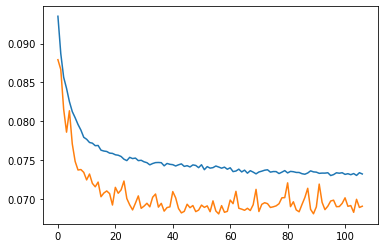

In [796]:
plt.plot(hist.history['mean_squared_error'][5:600])
plt.plot(hist.history['val_mean_squared_error'][5:600])